# Introduction

**This notebook elaborates on the modelling framework used by us and develops models for automated image captioning**

In [3]:
# Mounting the google drive containing the dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Importing relevant libraries**

In [4]:
import os
import time
import pickle
import pandas as pd
import numpy as np
np.random.seed(1087)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1087)
import keras
from keras.models import Model
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Embedding, LSTM, add, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')
import random
from collections import Counter, OrderedDict


**Checking TPU access**

In [5]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.115.35.162:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.115.35.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.35.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Loading required pickles created in the data preparation notebook**

In [6]:
base_path = '/content/gdrive/My Drive/Image-Captioning/'
path_images = base_path + 'Data/Images/'

# Loading the embedding matrix
with open(base_path + 'Pickles/' + 'embedding_matrix.p', 'rb') as input:
  embedding_matrix = pickle.load(input)

print('Shape of the embedding_matrix: ', np.shape(embedding_matrix))

# Loading the mapping of words to their integer representations
with open(base_path + 'Pickles/' + 'word_index.p', 'rb') as input:
  word_index = pickle.load(input)

vocab_size = len(word_index) + 1 # The number of words in the vocabulary

print('Number of words in vocabulary: ', vocab_size)

# Loading the train set
with open(base_path + 'Pickles/' + 'df_captions_train.p', 'rb') as input:
  df_captions_train = pickle.load(input)

list_train_images = list(df_captions_train['image'])
print('Number of images in training set: ', len(list_train_images))

# Loading the test set
with open(base_path + 'Pickles/' + 'df_captions_test.p', 'rb') as input:
  df_captions_test = pickle.load(input)
list_test_images = list(df_captions_test['image'])
print('Number of images in test set: ', len(list_test_images))

# Loading the val set
with open(base_path + 'Pickles/' + 'df_captions_val.p', 'rb') as input:
  df_captions_val = pickle.load(input)
list_val_images = list(df_captions_val['image'])
print('Number of images in val set: ', len(list_val_images))
with open(base_path + 'Pickles/' + 'max_length_caption.p', 'rb') as input:
  max_length_caption = pickle.load(input)

print('Maximum caption length: ', max_length_caption)

Shape of the embedding_matrix:  (782, 50)
Number of words in vocabulary:  782
Number of images in training set:  6068
Number of images in test set:  1011
Number of images in val set:  1012
Maximum caption length:  17


# Modelling strategy

**Our modelling strategy is inspired from the paper "Show and Tell: A Neural Image Caption Generator (Vinyals, Oriol, et al.)" with a few improvements of our own. We proceed in the following fashion:**

**1. Get dense representations of the words present in our vocabulary. We achieve this using GloVe-50D word embedding and has been implemented in the data preparation notebook.**

**2. Extract features from images using the following pre-trained models- VGG16, InceptionV3, ResNet50. The features are obtained from the last fully-connected layer of these models. For each image, this will give us 2048 features for each of InceptionV3 and ResNet50 and 4096 features for VGG16**

**3. Develop a LSTM based architecture which takes as input an image and the partial caption and outputs the next word of the caption (see note below).**

**4. As baselines, we separately evaluate the features obtained from the 3 pre-trained models using the same architecture. Then we try the same architecture by combining the features from the 3 pre-trained models. This will give us a vector of length 8192 for each image.**

**5. We pick the best model from Step 4 and perform extensive hyperparameter tuning for that model.**

**Note on input and output data structure for our model**

> **The same image will go as input in multiple steps. At each step, the image with partial caption will go as input and the ouput will be the next word of the caption. For ex. for the caption, 'sos a dog is playing eos', we'll start with input 'sos' and output 'a'. In the second step, the input becomes 'sos a' and ouput becomes 'dog'. In the third step, the input becomes 'sos a dog' and out is 'is' and so on.**


# Extracting features from images

**Extracting the InceptionV3 features of the images**

In [5]:
model_inception = InceptionV3(weights = 'imagenet', include_top = True)
# Removing the top layer since it involves a softmax layer to classify the 1000 categories of Imagenet
model_inception = Model(inputs = model_inception.input, outputs = model_inception.layers[-2].output)
# Not printing the model summary as model is too huge
#model_inception.summary()

96116736/96112376 [==============================] - 1s 0us/step


In [7]:
def get_image_features(model, list_image_files, file_path, target_size):
  '''
  For the input model, get image features for all the images present in list_image_files after resizing the images to target_size
  '''
  output_predictions = OrderedDict()  # An ordered dict which will contain image names as keys and the corresponding feature vector as value

  for image_file in list_image_files:
    image = load_img(file_path + image_file, target_size = target_size)
    image = img_to_array(image)
    image = preprocess_input(image)
    y_pred = model.predict(image.reshape((1, ) + image.shape)).flatten()
    output_predictions[image_file] = y_pred

  return output_predictions


In [8]:
# Obtaining image features from InceptionV3 
# We'll be saving the pickles as we keep getting features since the extraction takes > 20 mins
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_train_incv3.p'):
  output_predictions_train_incv3 = get_image_features(model_inception, list_train_images, path_images, (299, 299, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_train_incv3.p', 'wb') as output:
    pickle.dump(output_predictions_train_incv3, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_train_incv3.p', 'rb') as fp:
    output_predictions_train_incv3 = pickle.load(fp)

# Test set- InceptionV3
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_test_incv3.p'):
  output_predictions_test_incv3 = get_image_features(model_inception, list_test_images, path_images, (299, 299, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_test_incv3.p', 'wb') as output:
    pickle.dump(output_predictions_test_incv3, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_test_incv3.p', 'rb') as fp:
    output_predictions_test_incv3 = pickle.load(fp)

# Val set- InceptionV3
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_val_incv3.p'):
  output_predictions_val_incv3 = get_image_features(model_inception, list_val_images, path_images, (299, 299, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_val_incv3.p', 'wb') as output:
    pickle.dump(output_predictions_val_incv3, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_val_incv3.p', 'rb') as fp:
    output_predictions_val_incv3 = pickle.load(fp)

**Extracting the VGG16 features of the images.**

In [8]:
model_vgg = VGG16(weights = 'imagenet', include_top = True)
# Removing the top layer since it involves a softmax layer to classify the 1000 categories of Imagenet
model_vgg = Model(inputs = model_vgg.input, outputs = model_vgg.layers[-2].output)
model_vgg.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

In [9]:
# Obtaining image features from VGG16 
# Train set- VGG16
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_train_vgg.p'):
  output_predictions_train_vgg = get_image_features(model_vgg, list_train_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_train_vgg.p', 'wb') as output:
    pickle.dump(output_predictions_train_vgg, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_train_vgg.p', 'rb') as fp:
    output_predictions_train_vgg = pickle.load(fp)

# Test set- VGG16
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_test_vgg.p'):
  output_predictions_test_vgg = get_image_features(model_vgg, list_test_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_test_vgg.p', 'wb') as output:
    pickle.dump(output_predictions_test_vgg, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_test_vgg.p', 'rb') as fp:
    output_predictions_test_vgg = pickle.load(fp)

# Val set- VGG16
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_val_vgg.p'):
  output_predictions_val_vgg = get_image_features(model_vgg, list_val_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_val_vgg.p', 'wb') as output:
    pickle.dump(output_predictions_val_vgg, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_val_vgg.p', 'rb') as fp:
    output_predictions_val_vgg = pickle.load(fp)

**Extracting the ResNet50 features of the images**

In [10]:
model_res50 = ResNet50(weights = 'imagenet', include_top = True)
# Removing the top layer since it involves a softmax layer to classify the 1000 categories of Imagenet
model_res50 = Model(inputs = model_res50.input, outputs = model_res50.layers[-2].output)
#model_res50.summary()


102973440/102967424 [==============================] - 1s 0us/step


In [10]:
# Obtaining image features from ResNet50 
# Train set- ResNet50
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_train_res50.p'):
  output_predictions_train_res50 = get_image_features(model_res50, list_train_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_train_res50.p', 'wb') as output:
    pickle.dump(output_predictions_train_res50, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_train_res50.p', 'rb') as fp:
    output_predictions_train_res50 = pickle.load(fp)

# Test set- ResNet50
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_test_res50.p'):
  output_predictions_test_res50 = get_image_features(model_res50, list_test_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_test_res50.p', 'wb') as output:
    pickle.dump(output_predictions_test_res50, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_test_res50.p', 'rb') as fp:
    output_predictions_test_res50 = pickle.load(fp)

# Val set- ResNet50
if not os.path.isfile(base_path + 'Pickles/' + 'output_predictions_val_res50.p'):
  output_predictions_val_res50 = get_image_features(model_res50, list_val_images, path_images, (224, 224, 3))
  with open(base_path + 'Pickles/' + 'output_predictions_val_res50.p', 'wb') as output:
    pickle.dump(output_predictions_val_res50, output)

else:
  with open(base_path + 'Pickles/' + 'output_predictions_val_res50.p', 'rb') as fp:
    output_predictions_val_res50 = pickle.load(fp)

**Creating a new dictionary which contains features from all the three pre-trained models**

In [11]:
# Train set
output_predictions_train_all = OrderedDict()
for image in list(df_captions_train['image']):
  output_predictions_train_all[image] = np.append(output_predictions_train_res50[image],
                                                  output_predictions_train_incv3[image])
  output_predictions_train_all[image] = np.append(output_predictions_train_all[image],
                                                  output_predictions_train_vgg[image])

# Test
output_predictions_test_all = OrderedDict()
for image in list(df_captions_test['image']):
  output_predictions_test_all[image] = np.append(output_predictions_test_res50[image],
                                                  output_predictions_test_incv3[image])
  output_predictions_test_all[image] = np.append(output_predictions_test_all[image],
                                                  output_predictions_test_vgg[image])

# Val
output_predictions_val_all = OrderedDict()
for image in list(df_captions_val['image']):
  output_predictions_val_all[image] = np.append(output_predictions_val_res50[image],
                                                  output_predictions_val_incv3[image])
  output_predictions_val_all[image] = np.append(output_predictions_val_all[image],
                                                  output_predictions_val_vgg[image])

# Transforming data in a model appropriate format

**Creating a function which will transform the feature vectors in the appropriate format as described in the Modelling strategy section**

In [12]:
def get_model_input_output_data(dict_feature_vectors_images, df_captions, max_length_caption):
  '''
  For the image vectors provided in dict_feature_vectors_images and df_captions, output a list which contains the input and output arrays
  '''
  X_image = []
  X_captions = []
  y = []
  images_done = 0
  for image_file in list(df_captions['image']):
    images_done += 1
    encoded_caption = eval(df_captions.loc[df_captions['image'] == image_file, 'encoded_caption'].iloc[0])
    encoded_caption = list(filter(lambda a: a != word_index['unk'], encoded_caption))  # Removing the unknown keyword
    for idx in range(1, len(encoded_caption)):
      input_seq = encoded_caption[: idx]
      output_seq = encoded_caption[idx]
      input_seq = pad_sequences([input_seq], maxlen = max_length_caption, padding = 'post')[0]
      output_seq = to_categorical([output_seq], num_classes = vocab_size)[0]  # Will convert an integer array into binary tensor of dimension vocab_size
      X_captions.append(input_seq)
      X_image.append(dict_feature_vectors_images[image_file])

      y.append(output_seq)

    images_done += 1
  
  return [[np.array(X_image), np.array(X_captions)], np.array(y)]


In [13]:
# Generating training and validation sets for each of the models
# ResNet50
train_data_res50 = get_model_input_output_data(output_predictions_train_res50,
                                   df_captions_train,
                                   max_length_caption)

val_data_res50 = get_model_input_output_data(output_predictions_val_res50,
                                   df_captions_val,
                                   max_length_caption)

val_data_x_res50 = val_data_res50[0]
val_data_y_res50 = val_data_res50[1]

# InceptionV3
train_data_incv3 = get_model_input_output_data(output_predictions_train_incv3,
                                   df_captions_train,
                                   max_length_caption)

val_data_incv3 = get_model_input_output_data(output_predictions_val_incv3,
                                   df_captions_val,
                                   max_length_caption)

val_data_x_incv3 = val_data_incv3[0]
val_data_y_incv3 = val_data_incv3[1]

# VGG16
train_data_vgg = get_model_input_output_data(output_predictions_train_vgg,
                                   df_captions_train,
                                   max_length_caption)

val_data_vgg = get_model_input_output_data(output_predictions_val_vgg,
                                   df_captions_val,
                                   max_length_caption)

val_data_x_vgg = val_data_vgg[0]
val_data_y_vgg = val_data_vgg[1]

# Combined
train_data_all = get_model_input_output_data(output_predictions_train_all,
                                   df_captions_train,
                                   max_length_caption)

val_data_all = get_model_input_output_data(output_predictions_val_all,
                                   df_captions_val,
                                   max_length_caption)

val_data_x_all = val_data_all[0]
val_data_y_all = val_data_all[1]

# Baseline model architecture

In [14]:
# Defining properties relevant to specific pre-trained model
dict_model_properties = {}
dict_model_properties['InceptionV3'] = {'output_size' : 2048, 'target_size' : (299, 299, 3)}
dict_model_properties['VGG16'] = {'output_size' : 4096, 'target_size' : (224, 224, 3)}
dict_model_properties['ResNet50'] = {'output_size' : 2048, 'target_size' : (224, 224, 3)}
dict_model_properties['All'] = {'output_size' : 8192, 'target_size' : (224, 224, 3)}


In [19]:
def base_model(pre_trained_model_name):
  '''
  For the feature vectors corresponding to pre_trained_model_name, develop a model and print the eval metrics.
  '''
  input_layer_image = Input(shape = (dict_model_properties[pre_trained_model_name]['output_size'], ))  # Shape of the last layer
  image_encoder_l1 = Dropout(0.5)(input_layer_image)
  image_encoder_l2 = Dense(256, activation = 'relu')(image_encoder_l1)

  input_layer_caption = Input(shape = (max_length_caption, ))
  caption_encoder_l1 = Embedding(input_dim = np.shape(embedding_matrix)[0],
                                output_dim = np.shape(embedding_matrix)[1],
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero = True)(input_layer_caption)
  caption_encoder_l2 = Dropout(0.5)(caption_encoder_l1)
  caption_encoder_l3 = LSTM(256)(caption_encoder_l2)

  decoder_l1 = add([image_encoder_l2, caption_encoder_l3])
  decoder_l2 = Dense(256, activation = 'relu')(decoder_l1)

  output_layer = Dense(vocab_size, activation='softmax')(decoder_l2)

  model = Model([input_layer_image, input_layer_caption], output_layer)
  earlyStopping = EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                verbose = 0,
                                mode = 'max',
                                restore_best_weights = True)

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  if pre_trained_model_name == 'InceptionV3':
    train_data = train_data_incv3
    val_data_x = val_data_x_incv3
    val_data_y = val_data_y_incv3
  elif pre_trained_model_name == 'VGG16':
    train_data = train_data_vgg
    val_data_x = val_data_x_vgg
    val_data_y = val_data_y_vgg
  elif pre_trained_model_name == 'ResNet50':
    train_data = train_data_res50
    val_data_x = val_data_x_res50
    val_data_y = val_data_y_res50
  elif pre_trained_model_name == 'All':
    train_data = train_data_all
    val_data_x = val_data_x_all
    val_data_y = val_data_y_all
  
  hist = model.fit(x = train_data[0],
          y = train_data[1],
          batch_size = 128,
          epochs = 30,
          callbacks = [earlyStopping],
          validation_data = (val_data_x, val_data_y),
          verbose = 1)
  
  # plot metrics
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  return model

Epoch 1/30
  2/357 [..............................] - ETA: 11s - loss: 6.5724 - accuracy: 0.0625   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.0584s). Check your callbacks.


356/357 [============================>.] - ETA: 0s - loss: 4.0787 - accuracy: 0.2744WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0249s). Check your callbacks.


357/357 [==============================] - 25s 70ms/step - loss: 4.0784 - accuracy: 0.2744 - val_loss: 3.4222 - val_accuracy: 0.3351
Epoch 2/30
357/357 [==============================] - 23s 65ms/step - loss: 3.3524 - accuracy: 0.3295 - val_loss: 3.1464 - val_accuracy: 0.3563
Epoch 3/30
357/357 [==============================] - 23s 65ms/step - loss: 3.0838 - accuracy: 0.3495 - val_loss: 3.0444 - val_accuracy: 0.3668
Epoch 4/30
357/357 [==============================] - 23s 65ms/step - loss: 2.9056 - accuracy: 0.3666 - val_loss: 2.9988 - val_accuracy: 0.3727
Epoch 5/30
357/357 [==============================] - 23s 65ms/step - loss: 2.7710 - accuracy: 0.3745 - val_loss: 2.9574 - val_accuracy: 0.3874
Epoch 6/30
357/357 [==============================] - 24s 67ms/step - loss: 2.6516 - accuracy: 0.3850 - val_loss: 2.9761 - val_accuracy: 0.3815
Epoch 7/30
357/357 [==============================] - 23s 65ms/step - loss: 2.5447 - accuracy: 0.3967 - val_loss: 2.9884 - val_accuracy: 0.3882
Epo

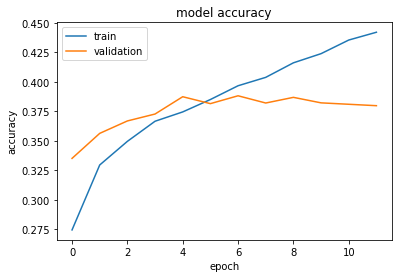

In [20]:
model_res50 = base_model(pre_trained_model_name = 'ResNet50')

Epoch 1/30
  2/357 [..............................] - ETA: 10s - loss: 16.0322 - accuracy: 0.0430   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0012s vs `on_train_batch_end` time: 0.0560s). Check your callbacks.


356/357 [============================>.] - ETA: 0s - loss: 4.7849 - accuracy: 0.2184WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0292s). Check your callbacks.


357/357 [==============================] - 25s 70ms/step - loss: 4.7843 - accuracy: 0.2185 - val_loss: 4.0434 - val_accuracy: 0.2647
Epoch 2/30
357/357 [==============================] - 23s 65ms/step - loss: 3.9774 - accuracy: 0.2788 - val_loss: 3.7232 - val_accuracy: 0.3002
Epoch 3/30
357/357 [==============================] - 23s 64ms/step - loss: 3.7490 - accuracy: 0.2961 - val_loss: 3.5822 - val_accuracy: 0.3141
Epoch 4/30
357/357 [==============================] - 23s 65ms/step - loss: 3.6072 - accuracy: 0.3068 - val_loss: 3.4738 - val_accuracy: 0.3240
Epoch 5/30
357/357 [==============================] - 23s 65ms/step - loss: 3.5043 - accuracy: 0.3141 - val_loss: 3.3917 - val_accuracy: 0.3307
Epoch 6/30
357/357 [==============================] - 23s 65ms/step - loss: 3.4242 - accuracy: 0.3224 - val_loss: 3.3428 - val_accuracy: 0.3380
Epoch 7/30
357/357 [==============================] - 23s 65ms/step - loss: 3.3600 - accuracy: 0.3278 - val_loss: 3.3082 - val_accuracy: 0.3432
Epo

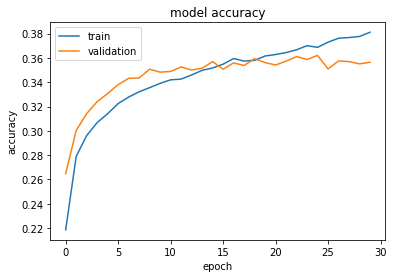

In [23]:
model_incv3 = base_model(pre_trained_model_name = 'InceptionV3')

Epoch 1/30
  2/357 [..............................] - ETA: 11s - loss: 6.6900 - accuracy: 0.0469   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.0619s). Check your callbacks.


356/357 [============================>.] - ETA: 0s - loss: 4.1028 - accuracy: 0.2676WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0261s). Check your callbacks.


357/357 [==============================] - 26s 72ms/step - loss: 4.1025 - accuracy: 0.2676 - val_loss: 3.4741 - val_accuracy: 0.3296
Epoch 2/30
357/357 [==============================] - 23s 65ms/step - loss: 3.3699 - accuracy: 0.3249 - val_loss: 3.2222 - val_accuracy: 0.3477
Epoch 3/30
357/357 [==============================] - 23s 65ms/step - loss: 3.0816 - accuracy: 0.3484 - val_loss: 3.1375 - val_accuracy: 0.3592
Epoch 4/30
357/357 [==============================] - 24s 66ms/step - loss: 2.8906 - accuracy: 0.3631 - val_loss: 3.1087 - val_accuracy: 0.3571
Epoch 5/30
357/357 [==============================] - 23s 65ms/step - loss: 2.7338 - accuracy: 0.3756 - val_loss: 3.1067 - val_accuracy: 0.3690
Epoch 6/30
357/357 [==============================] - 23s 65ms/step - loss: 2.5944 - accuracy: 0.3863 - val_loss: 3.1240 - val_accuracy: 0.3687
Epoch 7/30
357/357 [==============================] - 23s 66ms/step - loss: 2.4816 - accuracy: 0.3983 - val_loss: 3.1738 - val_accuracy: 0.3710
Epo

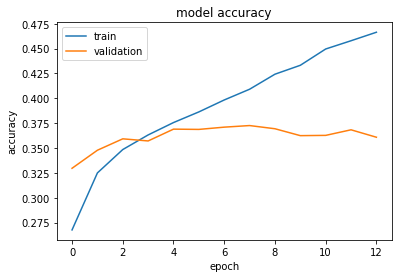

In [24]:
model_vgg = base_model(pre_trained_model_name = 'VGG16')

Epoch 1/30
  2/357 [..............................] - ETA: 11s - loss: 10.2456 - accuracy: 0.0977   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.0576s). Check your callbacks.


356/357 [============================>.] - ETA: 0s - loss: 4.4000 - accuracy: 0.2509WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_test_batch_end` time: 0.0256s). Check your callbacks.


357/357 [==============================] - 27s 75ms/step - loss: 4.3996 - accuracy: 0.2509 - val_loss: 3.6861 - val_accuracy: 0.3057
Epoch 2/30
357/357 [==============================] - 23s 65ms/step - loss: 3.6060 - accuracy: 0.3134 - val_loss: 3.3445 - val_accuracy: 0.3403
Epoch 3/30
357/357 [==============================] - 24s 66ms/step - loss: 3.3228 - accuracy: 0.3332 - val_loss: 3.2292 - val_accuracy: 0.3532
Epoch 4/30
357/357 [==============================] - 23s 65ms/step - loss: 3.1656 - accuracy: 0.3444 - val_loss: 3.1561 - val_accuracy: 0.3520
Epoch 5/30
357/357 [==============================] - 23s 65ms/step - loss: 3.0384 - accuracy: 0.3508 - val_loss: 3.1061 - val_accuracy: 0.3627
Epoch 6/30
357/357 [==============================] - 23s 65ms/step - loss: 2.9474 - accuracy: 0.3592 - val_loss: 3.0874 - val_accuracy: 0.3642
Epoch 7/30
357/357 [==============================] - 24s 66ms/step - loss: 2.8663 - accuracy: 0.3672 - val_loss: 3.0847 - val_accuracy: 0.3691
Epo

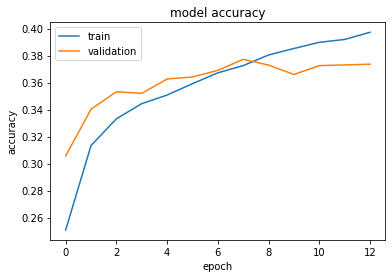

In [27]:
model_all = base_model(pre_trained_model_name = 'All')

# Final model architecture and hyperparameter tuning

**The best performances (best train and val accuracy combination) across various pre-trained networks:**

**InceptionV3: Train- 0.3517, Val- 0.3570**

**ResNet50:    Train- 0.3967, Val- 0.3882**

**VGG16:       Train- 0.4091, Val- 0.3726**

**All:         Train- 0.3726, Val- 0.3772**

**We're getting the best performance using ResNet50 features. We'll be performing extensive hyperparameter tuning on the same to arrive at the best model**


In [15]:
def final_model(dict_hyperparameters):
  input_layer_image = Input(shape = (dict_model_properties['ResNet50']['output_size'], ))  # Shape of the last layer
  image_encoder_l1 = Dropout(dict_hyperparameters['dropout_rate'])(input_layer_image)
  image_encoder_l2 = Dense(2*dict_hyperparameters['neurons'], activation = dict_hyperparameters['activation'])(image_encoder_l1)
  #image_encoder_l3 = BatchNormalization()(image_encoder_l2)

  input_layer_caption = Input(shape = (max_length_caption, ))
  caption_encoder_l1 = Embedding(input_dim = np.shape(embedding_matrix)[0],
                                output_dim = np.shape(embedding_matrix)[1],
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero = True)(input_layer_caption)
  caption_encoder_l2 = Dropout(dict_hyperparameters['dropout_rate'])(caption_encoder_l1)
  caption_encoder_l3 = Bidirectional(LSTM(dict_hyperparameters['neurons']))(caption_encoder_l2)

  decoder_l1 = add([image_encoder_l2, caption_encoder_l3])
  decoder_l2 = Dense(dict_hyperparameters['neurons'], activation = dict_hyperparameters['activation'])(decoder_l1)
  #decoder_l3 = BatchNormalization()(decoder_l2)

  output_layer = Dense(vocab_size, activation='softmax')(decoder_l2)

  model = Model([input_layer_image, input_layer_caption], output_layer)
  

  model.compile(loss = 'categorical_crossentropy', optimizer = dict_hyperparameters['optimizer'], metrics=['accuracy'])
  print(model.summary())

  train_data = train_data_res50
  val_data_x = val_data_x_res50
  val_data_y = val_data_y_res50
  
  earlyStopping = EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                verbose = 0,
                                mode = 'max',
                                restore_best_weights = True)
  
  hist = model.fit(train_data[0],
          train_data[1],
          batch_size = dict_hyperparameters['batch_size'],
          epochs = 50,
          callbacks = [earlyStopping],
          validation_data = (val_data_x, val_data_y),
          verbose = 2)


  # plot metrics
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  return model


**Manual hyperparameter tuning was performed on the above defined architecture. The key observations are as follows:**

1. Adding extra layers (for image encoder and final decoder) doesnt improves the performance.
Train acc- 0.3864
Val acc- 0.3791
However, using a bidirectional LSTM pushes improves val accuracy to 0.3898, train- 0.4025


2. Changing dropout from 0.5 to 0.6: 
Train acc- 0.3865
Val acc- 0.3763

3. Changing dropout from 0.5 to 0.4:
Train acc- 0.4356m
Val acc-  0.3812

4. Changing batch size:
batch 64: Train acc- 0.3976, Val acc-  0.3864
batch 32: Train acc- 0.3698, Val acc-  0.3788
batch 128: Train acc- 0.3904, Val acc-  0.3767

5. Changing the optimizer
RMSProp- Train acc- 0.3572, Val acc-  0.3624
SGD: Train acc- 0.22, Val acc-  0.2168

6. Changing the activation function
Using ELU doesn't improves performance

Adding batch normalization doesn't improves the performance.

In [16]:
# the best model was obtained using the following hyperparameters:
dict_hyperparameters = {'neurons' : 256,
                        'dropout_rate' : 0.5,
                        'activation' : 'relu',
                        'optimizer' : 'adam',
                        'batch_size' : 64
                        }

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 17, 50)       39100       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

714/714 - 34s - loss: 3.9344 - accuracy: 0.2867 - val_loss: 3.3155 - val_accuracy: 0.3436
Epoch 2/50
714/714 - 32s - loss: 3.2836 - accuracy: 0.3368 - val_loss: 3.1174 - val_accuracy: 0.3602
Epoch 3/50
714/714 - 32s - loss: 3.0315 - accuracy: 0.3558 - val_loss: 3.0260 - val_accuracy: 0.3731
Epoch 4/50
714/714 - 32s - loss: 2.8590 - accuracy: 0.3727 - val_loss: 2.9766 - val_accuracy: 0.3778
Epoch 5/50
714/714 - 32s - loss: 2.7164 - accuracy: 0.3841 - val_loss: 2.9481 - val_accuracy: 0.3830
Epoch 6/50
714/714 - 32s - loss: 2.6067 - accuracy: 0.3962 - val_loss: 2.9682 - val_accuracy: 0.3898
Epoch 7/50
714/714 - 32s - loss: 2.4997 - accuracy: 0.4028 - val_loss: 3.0006 - val_accuracy: 0.3935
Epoch 8/50
714/714 - 32s - loss: 2.4043 - accuracy: 0.4132 - val_loss: 3.0173 - val_accuracy: 0.3914
Epoch 9/50
714/714 - 32s - loss: 2.3203 - accuracy: 0.4268 - val_loss: 3.0426 - val_accuracy: 0.3935
Epoch 10/50
714/714 - 32s - loss: 2.2401 - accuracy: 0.4338 - val_loss: 3.1055 - val_accuracy: 0.3852


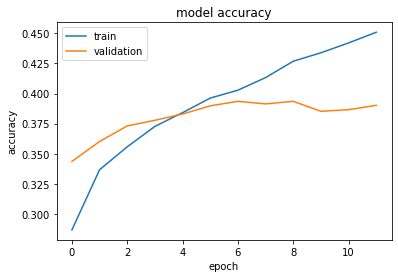

In [17]:
final_model = final_model(dict_hyperparameters)

In [18]:
final_model.save_weights(base_path + 'Pickles/' + 'model.h5')


In [19]:
dict_idx_to_word = {}
for word, idx in word_index.items():
  dict_idx_to_word[idx] = word


**We'll be implementing two prediction mechanisms:**

**1. Greedy search- Pick the word with the highest probability conditioned on the existing words.**

**2. Beam Search- Try combinations of different beam lengths**

In [59]:
def predict_caption_greedy_search(image_name, model_name, dict_image_features, fl_display_image = 0):
  #image = load_img(path_images + image_name, target_size = (224, 224, 3))
  image = load_img(path_images + image_name, target_size = dict_model_properties[model_name]['target_size'])
  if fl_display_image == 1:
    plt.imshow(image)
    plt.show()
  output_sequence = 'sos'
  curr_words = 1
  X_image = np.array([dict_image_features[image_name]])
  X_caption = [word_index['sos']]

  while curr_words < max_length_caption:
    padded_seq = np.array(pad_sequences([X_caption], max_length_caption, padding = 'post')[0])
    X_image = X_image.reshape(1,-1)
    padded_seq = padded_seq.reshape(1,-1)
    
    y_pred = final_model.predict([[X_image], [padded_seq]])
    y_pred = np.argmax(y_pred)

    new_word = dict_idx_to_word[y_pred]
    output_sequence = output_sequence + ' ' + new_word
    curr_words += 1
    X_caption.append(y_pred)

    if new_word == 'eos':
      return output_sequence
  
  return output_sequence
    

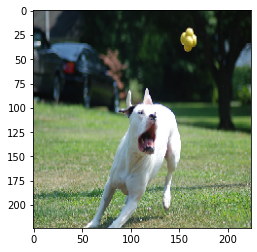

Predicted caption:  a dog runs with a red ball
True caption:  a white dog running after a yellow ball
BLEU Score is:  0.8282477531331041


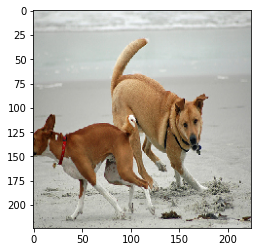

Predicted caption:  two dogs play in the snow
True caption:  two dogs playing together on a beach
BLEU Score is:  0.8210967436686386


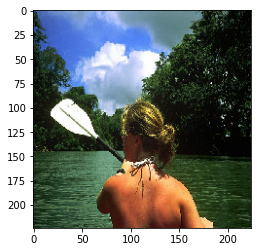

Predicted caption:  a woman in a boat
True caption:  a woman with a unk
BLEU Score is:  0.7952707287670506


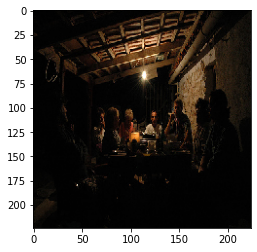

Predicted caption:  a man in a
True caption:  a group of people gathered around in the dark
BLEU Score is:  0.7896895367562644


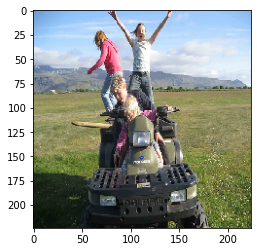

Predicted caption:  a man in a red shirt is standing on a
True caption:  children ride a unk in a field
BLEU Score is:  0.6865890479690392


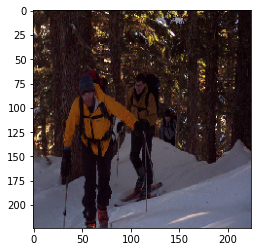

Predicted caption:  a man is skiing down a slope
True caption:  two people wearing yellow unk skiing
BLEU Score is:  0.7598356856515925


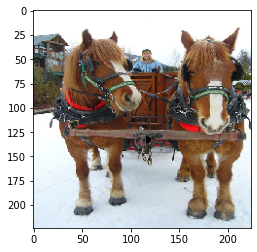

Predicted caption:  a horse a horse
True caption:  two unk horses unk a cart through the snow
BLEU Score is:  0.7427498127683173


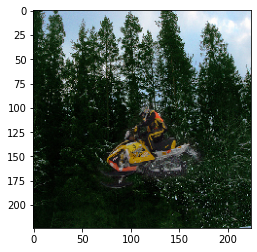

Predicted caption:  a man is kayaking
True caption:  a unk flies through the air
BLEU Score is:  0.7745966692414834


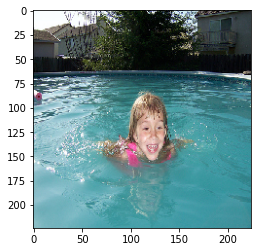

Predicted caption:  a girl in a pool
True caption:  a girl swimming in a pool
BLEU Score is:  0.8228020420406904


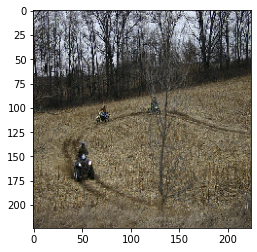

Predicted caption:  a dog runs across the grass
True caption:  three people are riding around on unk and unk
BLEU Score is:  0.7652058832556895
5.339001417160034


In [32]:
t0 = time.time() #
for image_file in list(df_captions_test.head(10)['image']):
#image_file = '1119463452_69d4eecd08.jpg'
  predicted_caption = predict_caption_greedy_search(image_file, 'ResNet50', output_predictions_test_res50)
  true_caption = df_captions_test.loc[df_captions_test['image'] == image_file, 'caption_cleaned'].iloc[0]
  print('Predicted caption: ', predicted_caption[4:-4])
  print('True caption: ', true_caption[4:-4])
  print('BLEU Score is: ', sentence_bleu(true_caption, predicted_caption))
print(time.time()-t0)

**Obtaining BLEU scores for all the examples**

In [40]:
t0 = time.time() #
df_BLEU_train = pd.DataFrame(columns = ['image', 'BLEU'])
df_BLEU_train['image'] = df_captions_train['image']

for image_file in list(df_captions_train['image']):
  predicted_caption = predict_caption_greedy_search(image_file, 'ResNet50', output_predictions_train_res50)
  true_caption = df_captions_train.loc[df_captions_train['image'] == image_file, 'caption_cleaned'].iloc[0]
  df_BLEU_train.loc[df_BLEU_train['image'] == image_file, 'BLEU'] = sentence_bleu(true_caption, predicted_caption)
print(time.time()-t0)

with open(base_path + 'Pickles/' + 'BLEU_train.p', 'wb') as fp:
  pickle.dump(df_BLEU_train, fp)

3752.8451342582703


In [41]:
t0 = time.time() #
df_BLEU_test = pd.DataFrame(columns = ['image', 'BLEU'])
df_BLEU_test['image'] = df_captions_test['image']

for image_file in list(df_captions_test['image']):
  predicted_caption = predict_caption_greedy_search(image_file, 'ResNet50', output_predictions_test_res50)
  true_caption = df_captions_test.loc[df_captions_test['image'] == image_file, 'caption_cleaned'].iloc[0]
  df_BLEU_test.loc[df_BLEU_test['image'] == image_file, 'BLEU'] = sentence_bleu(true_caption, predicted_caption)
print(time.time()-t0)

with open(base_path + 'Pickles/' + 'BLEU_test.p', 'wb') as fp:
  pickle.dump(df_BLEU_test, fp)

627.2142317295074


In [47]:
t0 = time.time() #
df_BLEU_val = pd.DataFrame(columns = ['image', 'BLEU'])
df_BLEU_val['image'] = df_captions_val['image']

for image_file in list(df_captions_val['image']):
  predicted_caption = predict_caption_greedy_search(image_file, 'ResNet50', output_predictions_val_res50)
  true_caption = df_captions_val.loc[df_captions_val['image'] == image_file, 'caption_cleaned'].iloc[0]
  df_BLEU_val.loc[df_BLEU_val['image'] == image_file, 'BLEU'] = sentence_bleu(true_caption, predicted_caption)
print(time.time()-t0)

with open(base_path + 'Pickles/' + 'BLEU_val.p', 'wb') as fp:
  pickle.dump(df_BLEU_val, fp)

380.7804570198059


**Checking model stability**

In [56]:
mean_BLEU_train = df_BLEU_train['BLEU'].mean()
mean_BLEU_val = df_BLEU_val['BLEU'].mean()
mean_BLEU_test = df_BLEU_test['BLEU'].mean()

print('Mean BLEU on the train set: ', round(mean_BLEU_train,3))
print('Mean BLEU on the val set: ', round(mean_BLEU_val,3))
print('Mean BLEU on the test set: ', round(mean_BLEU_test,3))

Mean BLEU on the train set:  0.759
Mean BLEU on the val set:  0.754
Mean BLEU on the test set:  0.756


**Future work:**

1. Beam search
2. Attention based LSTM
3. Automated hyperparameter tuning 